In [12]:
from datetime import datetime, time, timedelta

import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
from ocf_blosc2 import Blosc2

In [13]:
###HRV
hrv_1 = xr.open_dataset(
    "/data/climatehack/official_dataset/hrv/2020/7.zarr.zip",
    engine="zarr",
    consolidated=True,
)
hrv_2 = xr.open_dataset(
    "/data/climatehack/official_dataset/hrv/2021/1.zarr.zip",
    engine="zarr",
    consolidated=True,
)

print("time stamps are every: ", hrv_1["time"][2].item() - hrv_1["time"][1].item(), " ns (5 mins)")
hrv_1

time stamps are every:  300000000000  ns (5 mins)


<xarray.Dataset>
Dimensions:                      (channel: 1, time: 6721, y_geostationary: 592,
                                  x_geostationary: 684)
Coordinates:
  * channel                      (channel) <U3 'HRV'
  * time                         (time) datetime64[ns] 2020-07-01T04:00:00 .....
  * x_geostationary              (x_geostationary) float64 -1.089e+06 ... -4....
  * y_geostationary              (y_geostationary) float64 4.449e+06 ... 5.04...
Data variables:
    data                         (time, y_geostationary, x_geostationary, channel) float16 ...
    x_geostationary_coordinates  (time, x_geostationary) float64 ...
    y_geostationary_coordinates  (time, y_geostationary) float64 ...

In [85]:
def get_hrv_at_time(year, month, day, hour, minute):
    assert year in [2020, 2021], "year not 2020 or 2021"
    assert minute % 5 == 0, "minute not multiple of 5"
    assert 1 <= hour <= 24, "hour not between 4 and 21"
    try: 
        date = datetime(year=year, month=month, day=day, hour=hour, minute=minute)
        print(date)
    except:
        print("date invalid")
        return
    hrv = xr.open_dataset(
        f"/data/climatehack/official_dataset/hrv/{year}/{month}.zarr.zip",
        engine="zarr",
        consolidated=True,
    )
    return hrv["data"].sel(time=date).to_numpy()[::-1]

def plot_hrv_at_time(year, month, day, hour, minute):
    plt.imshow(get_hrv_at_time(year, month, day, hour, minute))

2020-07-22 04:35:00


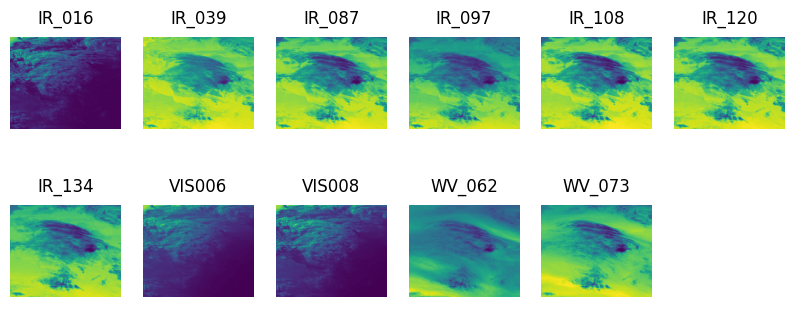

In [86]:
##nonhrv

#TODO swap axes so the different channels are on the first axis
def get_nonhrv_at_time(year, month, day, hour, minute):
    assert year in [2020, 2021], "year not 2020 or 2021"
    assert minute % 5 == 0, "minute not multiple of 5"
    assert 4 <= hour <= 21, "hour not between 4 and 21"
    try: 
        date = datetime(year=year, month=month, day=day, hour=hour, minute=minute)
        print(date)
    except:
        print("date invalid")
        return
    nonhrv = xr.open_dataset(
        f"/data/climatehack/official_dataset/nonhrv/{year}/{month}.zarr.zip",
        engine="zarr",
        consolidated=True,
    )
    return nonhrv["data"].sel(time=date).to_numpy()[::-1]

def plot_nonhrv_at_time(year, month, day, hour, minute, channel = "all"):
    channel_names = np.array(['IR_016', 'IR_039', 'IR_087', 'IR_097', 'IR_108', 'IR_120', 'IR_134', 'VIS006', 'VIS008', 'WV_062', 'WV_073'], dtype='<U6')
    to_plot = get_nonhrv_at_time(year, month, day, hour, minute)

    if channel == "all":
        num_rows, num_cols, num_images = 2, 6, 11
        fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 4))

        # Plot each image in the grid
        for i in range(num_rows):
            for j in range(num_cols):
                index = i * num_cols + j
                if index < num_images:
                    axes[i, j].imshow(to_plot[:,:,index])  # Assuming grayscale images
                    axes[i, j].set_title(channel_names[index])
                axes[i, j].axis('off')  # Turn off axis labels for cleaner display
    else:
        plt.imshow(to_plot[:,:,np.where(channel_names == channel)[0].item()])
            


plot_nonhrv_at_time(2020, 7, 22, 4, 35, channel="all")

In [87]:
nwp = xr.open_dataset(
    "/data/climatehack/official_dataset/weather/2020/7.zarr.zip",
    engine="zarr",
    consolidated=True,
)

data_vars = np.array(list(nwp.data_vars.keys()))
print(list(data_vars))
print(len(data_vars))

['alb_rad', 'aswdifd_s', 'aswdir_s', 'cape_con', 'clch', 'clcl', 'clcm', 'clct', 'h_snow', 'omega_1000', 'omega_700', 'omega_850', 'omega_950', 'pmsl', 'relhum_2m', 'runoff_g', 'runoff_s', 't_2m', 't_500', 't_850', 't_950', 't_g', 'td_2m', 'tot_prec', 'u_10m', 'u_50', 'u_500', 'u_850', 'u_950', 'v_10m', 'v_50', 'v_500', 'v_850', 'v_950', 'vmax_10m', 'w_snow', 'ww', 'z0']
38


2020-01-01 22:00:00
[5]


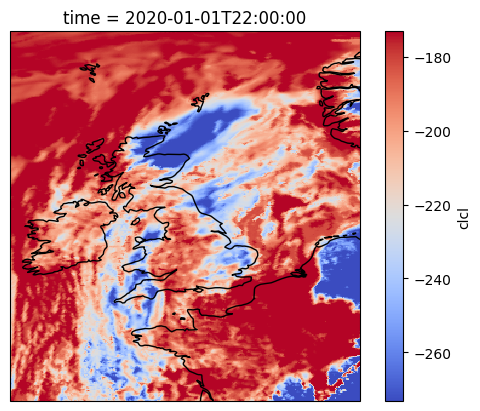

In [88]:
#numerical weather forcasts
def get_weather_at_time(year, month, day, hour, minute):
    assert year in [2020, 2021], "year not 2020 or 2021"
    assert minute % 5 == 0, "minute not multiple of 5"
    assert 4 <= hour <= 22, "hour not between 4 and 22"
    data_vars = np.array(list(nwp.data_vars.keys()))

    try: 
        date = datetime(year=year, month=month, day=day, hour=hour, minute=minute)
        print(date)
    except:
        print("date invalid")
        return

    weather = xr.open_dataset(
        f"/data/climatehack/official_dataset/weather/{year}/{month}.zarr.zip",
        engine="zarr",
        consolidated=True,
    )

    out = [weather[data_var].sel(time=date) - 273.15 for data_var in data_vars]  #273.15 is because Kelvin!!!
    np.vstack(out)


    return out

def plot_weather_at_time(year, month, day, hour, minute, channel = "all"):
    channel_names = np.array(['alb_rad', 'aswdifd_s', 'aswdir_s', 'cape_con', 'clch', 'clcl', 'clcm', 'clct', 'h_snow', 'omega_1000', 'omega_700', 'omega_850', 'omega_950', 'pmsl', 'relhum_2m', 'runoff_g', 'runoff_s', 't_2m', 't_500', 't_850', 't_950', 't_g', 'td_2m', 'tot_prec', 'u_10m', 'u_50', 'u_500', 'u_850', 'u_950', 'v_10m', 'v_50', 'v_500', 'v_850', 'v_950', 'vmax_10m', 'w_snow', 'ww', 'z0'])
    to_plot = get_weather_at_time(year, month, day, hour, minute)


    if channel == "all":
        num_rows, num_cols, num_images = 4, 10, 38
        fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 5), subplot_kw={'projection': ccrs.PlateCarree()})

        # Plot each image in the grid
        for i in range(num_rows):
            for j in range(num_cols):
                index = i * num_cols + j
                if index < num_images:
                    # axes[i, j].imshow(to_plot[index])  # Assuming grayscale images
                    (to_plot[index]).plot.pcolormesh(
                        ax=axes[i, j],
                        transform=ccrs.PlateCarree(),
                        x="longitude",
                        y="latitude",
                        add_colorbar=False,
                        cmap="coolwarm",
                    )  # type: ignore
                    axes[i, j].set_title(channel_names[index])
                axes[i, j].axis('off')  # Turn off axis labels for cleaner display
                axes[i, j].coastlines()  #downloads somethingn somehow cuz cartopy ig
    else:
        axes = plt.axes(projection=ccrs.PlateCarree())
        print(np.where(channel_names == channel)[0])
        (to_plot[np.where(channel_names == channel)[0].item()]).plot.pcolormesh(
            ax=axes,
            transform=ccrs.PlateCarree(),
            x="longitude",
            y="latitude",
            add_colorbar=True,
            cmap="coolwarm",
        )  # type: ignore
        axes.coastlines()


plot_weather_at_time(2020, 1, 1, 22, 0, channel = "clcl")

In [89]:
##skipping aerosols bc meh 

In [90]:
from datetime import timezone
date = datetime(year=2020, month=3, day=22, hour=15, minute=30, tzinfo=timezone(timedelta(hours=0)))
pv = pd.read_parquet(f"/data/climatehack/official_dataset/pv/{2020}/{3}.parquet")
print(pv.index[:5])
# print(pv.loc[date])     #generation_wh, power
date = datetime(year=2021, month=3, day=22, hour=15, minute=30, tzinfo=timezone(timedelta(hours=0)))
pv = pd.read_parquet(f"/data/climatehack/official_dataset/pv/{2021}/{3}.parquet")
pv.loc[date][0:-1:10].index     #generation_wh, power
ss_id = 2607

MultiIndex([('2020-03-01 00:00:00+00:00', 2607),
            ('2020-03-01 00:00:00+00:00', 2631),
            ('2020-03-01 00:00:00+00:00', 2657),
            ('2020-03-01 00:00:00+00:00', 2660),
            ('2020-03-01 00:00:00+00:00', 2729)],
           names=['timestamp', 'ss_id'])


In [91]:
def get_pv_at_time(year, month, day, hour, minute, ss_id=2607, four_hours = False):
    assert year in [2020, 2021], "year not 2020 or 2021"
    assert minute % 5 == 0, "minute not multiple of 5"
    assert 1 <= hour <= 24, "hour not between 4 and 21"
    try: 
        date = datetime(year=year, month=month, day=day, hour=hour, minute=minute, tzinfo=timezone(timedelta(hours=0)))
        print(date)
    except:
        print("date invalid")
        return
    pv = pd.read_parquet(f"/data/climatehack/official_dataset/pv/{year}/{month}.parquet")

    if four_hours:
        id_select = pv.loc[lambda x: x.index.get_level_values("ss_id") == ss_id] 
        return id_select.loc[lambda x: (date <= x.index.get_level_values("timestamp")) & (x.index.get_level_values("timestamp") < (date + pd.Timedelta(hours=4)))].to_numpy()
    else:
        return pv.loc([(date, ss_id)]).to_numpy()

def plot_pv_at_time(year, month, day, hour, minute, ss_id=2607, four_hours = False):
    pvs = get_pv_at_time(year, month, day, hour, minute, ss_id=ss_id, four_hours=four_hours)          
    #some valid ss_id: 2834 2997 3085 26999 27020 27058

    indices = list(range(len(pvs)))
    plt.plot(indices, pvs[:,1], linestyle="-")

    plt.xlabel('time (10 = 50 min)')
    plt.ylabel('power normalized')
    plt.title('power normalized to capacity over 4 hours')

    plt.show()



2020-08-10 10:00:00+00:00


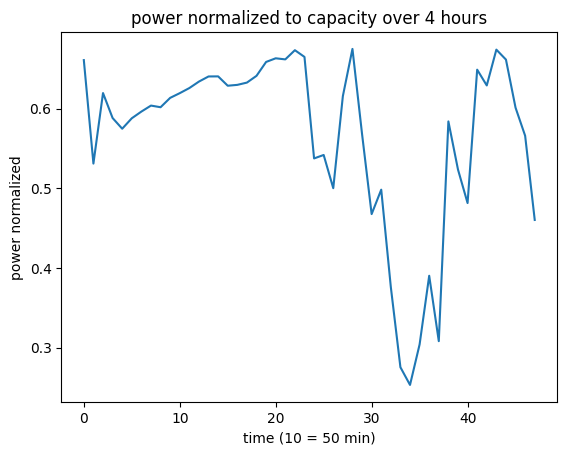

pv
2020-08-10 10:00:00
hrv
2020-08-10 10:00:00
nonhrv
2020-08-10 10:00:00
weather


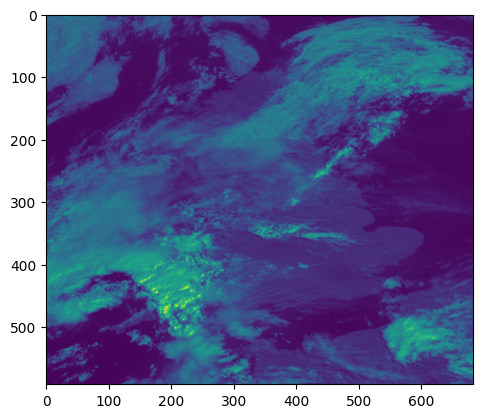

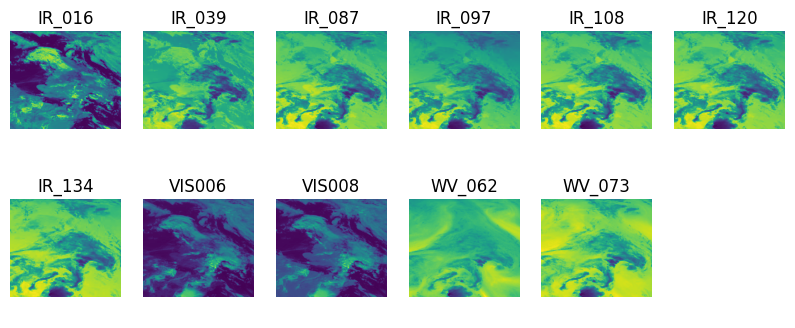

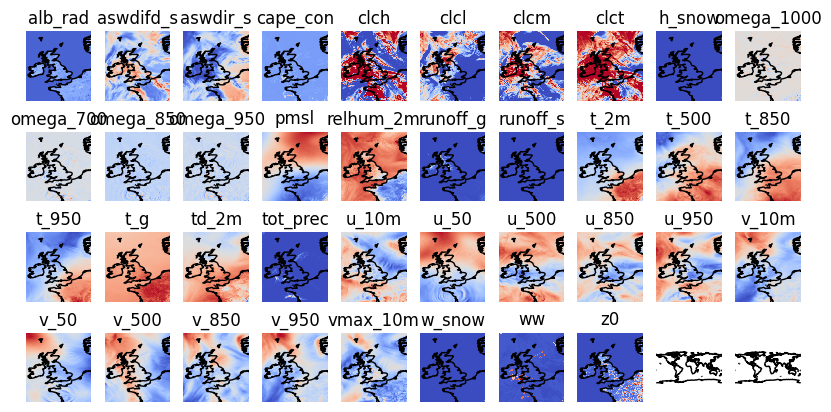

In [94]:
def get_all_data_at_time(year, month, day, hour, minute):
    plot_pv_at_time(year, month, day, hour, minute, ss_id=2607, four_hours = True)
    print("pv")
    plot_hrv_at_time(year, month, day, hour, minute)
    print("hrv")
    plot_nonhrv_at_time(year, month, day, hour, minute)
    print("nonhrv")
    plot_weather_at_time(year, month, day, hour, minute)
    print("weather")

# get_pv_at_time(2021, 8, 1, 12, 10, ss_id=2607, four_hours=True) 
get_all_data_at_time(2020, 8, 10, 10, 0)